<!---
Latex Macros
-->
$$
\newcommand{\bar}{\,|\,}
\newcommand{\Xs}{\mathcal{X}}
\newcommand{\Ys}{\mathcal{Y}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\weights}{\mathbf{w}}
\newcommand{\balpha}{\boldsymbol{\alpha}}
\newcommand{\bbeta}{\boldsymbol{\beta}}
\newcommand{\aligns}{\mathbf{a}}
\newcommand{\align}{a}
\newcommand{\source}{\mathbf{s}}
\newcommand{\target}{\mathbf{t}}
\newcommand{\ssource}{s}
\newcommand{\starget}{t}
\newcommand{\repr}{\mathbf{f}}
\newcommand{\repry}{\mathbf{g}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\prob}{p}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\DeclareMathOperator{\argmin}{argmin}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
\newcommand{\length}[1]{\text{length}(#1) }
\newcommand{\indi}{\mathbb{I}}
$$

# Assignment 3

## <font color='green'>Setup 1</font>: Load Libraries
This cell loads libraries important for evaluation and assessment of your model. **Do not change, move or copy it.**

In [1]:
%%capture
%load_ext autoreload
%autoreload 2
%matplotlib inline
#! SETUP 1 - DO NOT CHANGE, MOVE NOR COPY
import sys, os
_snlp_book_dir = "../../../../../"
sys.path.append(_snlp_book_dir)
# docker image contains tensorflow 0.10.0rc0. We will support execution of only that version!
import statnlpbook.nn as nn

In [2]:
import tensorflow as tf
import numpy as np
import re
import math
import itertools
import os
import sys
import time
import argparse
# For report:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# MODEL COMPONENTS
class WordEmbedder(object):
    def __init__(self, w_size, vocab_size=None):
        embed_path = 'embeddings/glove{}.npy'.format(w_size)
        if os.path.exists(embed_path):
            init_embed = np.load(embed_path).astype(np.float32)
            self.vocab_size = init_embed.shape[0]
        else:
            self.vocab_size = vocab_size
            init_embed = tf.zeros([vocab_size, w_size], dtype=np.float32)
        with tf.variable_scope("WordEmbedder", reuse=None):
            self.embeddings = tf.get_variable('W', initializer=init_embed, trainable=False)

    def embed(self, story):
        batch_size = get_this_batch_size(story)
        sentences = [tf.reshape(x, [batch_size, -1]) for x in
                     tf.split(1, 5, story)]  # 5 times [batch_size x max_length]

        # [batch_size x max_seq_length x input_size]
        words_embedded = [tf.nn.embedding_lookup(self.embeddings, sentence) for sentence in sentences]

        return words_embedded

    
class NonLinearClassifier(object):
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        hidden_size = input_size
        self.target_size = 5
        initializer = tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32)
        with tf.variable_scope('NonLinear', reuse=None, initializer=initializer):
            with tf.variable_scope('Hidden', reuse=None):
                self.w0 = tf.get_variable('Weights', [input_size, hidden_size])
                self.b0 = tf.get_variable('Biases', [1, hidden_size])
            with tf.variable_scope('Output', reuse=None):
                self.w1 = tf.get_variable('Weights', [hidden_size, output_size])
                self.b1 = tf.get_variable('Biases', [1, output_size])

    def classify(self, logits):
        logits_flat = tf.reshape(logits, [-1, self.input_size])
        nl = tf.matmul(tf.nn.relu(tf.matmul(logits_flat, self.w0) + self.b0), self.w1) + self.b1
        return tf.reshape(nl, [-1, self.target_size, self.target_size])

    @property
    def l2_loss(self):
        return tf.nn.l2_loss(self.w0) + tf.nn.l2_loss(self.w1)

    
class SentenceEmbedder(object):
    def __init__(self, cell_size):
        self.cell_size = cell_size
        self.initializer = tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32)
        with tf.variable_scope('SentEmbedder', reuse=None):
            self.embed_cell = tf.nn.rnn_cell.GRUCell(cell_size, activation=tf.nn.relu)

    @property
    def l2_loss(self):
        return 0

    def embed(self, inputs, seq_lens, state):
        """
        :param inputs: List of input arrays 5*[batch_size x sent_len x word_embed_size]
        :param seq_lens:
        :param state:
        :return: 5-lists output_list, all_output_list; [sent_embed_size x cell_size] state
        """
        batch_size = get_this_batch_size(inputs[0])
        sent_len = tf.shape(inputs[0])[1]
        output_list = []
        all_output_list = []
        reuse_scope=None

        for i in range(len(inputs)):
            if i > 0:
                reuse_scope = True
            with tf.variable_scope('SentEmbedder', reuse=reuse_scope) as scope:
                output, state = tf.nn.dynamic_rnn(
                    self.embed_cell, inputs[i],
                    sequence_length=seq_lens[:, i],
                    initial_state=state,
                    dtype=tf.float32,
                    scope=scope)
            # [batch_size x sent_len x cell_size]
            all_output_list.append(output)
            # Flatten from a vector per sentence in array to flat
            output_flat = tf.reshape(output, [-1, output.get_shape()[2].value])
            # Index the last output row for each
            index = tf.range(0, batch_size) * sent_len + seq_lens[:, i] - 1
            # Append the array containing [batch_size x cell_size]
            output_list.append(tf.gather(output_flat, index))

        return output_list, all_output_list, state


class AttnSentenceEmbedder(SentenceEmbedder):
    def __init__(self, cell_size):
        SentenceEmbedder.__init__(self, cell_size)

        with tf.variable_scope('SentEmbedder', reuse=None):
            # Add additional variables not defined by SentenceEmbedder class
            self.Wy = tf.get_variable('W_y', [cell_size, cell_size], dtype=tf.float32, initializer=self.initializer)
            self.Wh = tf.get_variable('W_h', [cell_size, cell_size], dtype=tf.float32, initializer=self.initializer)
            self.Wm = tf.get_variable('W_m', [cell_size, 1], dtype=tf.float32, initializer=self.initializer)
            self.Wp = tf.get_variable('W_p', [cell_size, cell_size], dtype=tf.float32, initializer=self.initializer)
            self.Wx = tf.get_variable('W_x', [cell_size, cell_size], dtype=tf.float32, initializer=self.initializer)
            self.skipW = tf.get_variable('W_skip', dtype=tf.float32, initializer=[0.5, 0.5])

    @property
    def l2_loss(self):
        # Override the SentenceEmbedder base l2_loss, which is 0
        return (tf.nn.l2_loss(self.Wm) +
                tf.nn.l2_loss(self.Wh) +
                tf.nn.l2_loss(self.Wp) +
                tf.nn.l2_loss(self.Wx) +
                tf.nn.l2_loss(self.Wy))

    def embed_with_attention(self, inputs, seq_lens, state, skip=False):

        batch_size = get_this_batch_size(inputs[0])
        sent_len = tf.shape(inputs[0])[1]
        output_list, all_output_list, final_state = self.embed(inputs, seq_lens, state)
        sent_rep = [None for _ in range(len(output_list))]

        with tf.variable_scope('SentEmbedder', reuse=True):
            # Need to batch_matmul if the data in is matrix (Y, M)
            Wy_batch = tf.tile(tf.expand_dims(self.Wy, 0), [batch_size, 1, 1])  # batch_size x [cell_size x cell_size]
            Wh = self.Wh
            Wm = tf.tile(tf.expand_dims(self.Wm, 0), [batch_size, 1, 1])  # batch_size x [cell_size x 1]

        for t in range(len(sent_rep)):
            Y = all_output_list[t]  # [batch_size x sent_len x cell_size]
            next_t = t + 1
            if t == len(sent_rep) - 1:
                next_t = 0

            h = output_list[next_t]  # [batch_size x cell_size]

            # batch_size * [sent_len x cell_size] x [cell_size x cell_size] => [batch_size x sent_len x cell_size]
            M1 = tf.batch_matmul(Y, Wy_batch)
            # batch_size * [1 x cell_size] x [cell_size x cell_size] => # batch_size x [sent_len x cell_size]
            M2 = tf.tile(tf.expand_dims(tf.matmul(h, Wh), 1), [1, sent_len, 1])
            M = tf.nn.relu(tf.add_n([M1, M2]))  # [sent_len x cell_size]

            # batch_size * [sent_len x cell_size] * [cell_size x 1]
            # => batch_size * [sent_len x 1] => <squeeze+softmax> batch_size x sent_len
            # => <expand> batch_size x 1 x sent_len
            alphas = tf.expand_dims(tf.nn.softmax(tf.squeeze(tf.batch_matmul(M, Wm))), 1)

            # representation r = Y*alphas^T : batch_size * [1 x sent_len] x [sent_len x cell_size]
            r = tf.squeeze(tf.batch_matmul(alphas, Y))
            h_ = tf.nn.relu(tf.matmul(r, self.Wp) + tf.matmul(final_state, self.Wx))

            # representation r [batch_size x cell_size]
            sent_rep[next_t] = h_

        if skip:
            return sent_rep, output_list, final_state
        else:
            return sent_rep, final_state

    def embed_with_skip(self, inputs, seq_lens, state):
        embed_attn, embed_init, final_state = self.embed_with_attention(inputs, seq_lens, state, skip=True)
        assert len(embed_attn) == len(embed_init)

        skipW = self.skipW / tf.reduce_sum(self.skipW)
        embed = [skipW[0] * embed_attn[i] + skipW[1] * embed_init[i] for i in range(len(embed_attn))]
        return embed, final_state


In [4]:
# BASIC MODEL CLASS
class Model(object):
    def __init__(self, args_dict, save_path, use_own_sess=True):
        """
        Initialize the model object.
        :param args_dict: must have keys and corresponding values for
        word_embed_size, sent_embed_size, attn_scorer_size, read_cycles
        """
        self.target_size = 5
        self.word_embed_size = args_dict['word_embed_size']
        self.sent_embed_size = args_dict['sent_embed_size']
        self.attn_scorer_size = args_dict['attn_scorer_size']
        self.read_cycles = args_dict['read_cycles']
        self.encoder_size = args_dict['encoder_size']
        self.reg = args_dict['reg']
        self.vocab_size = args_dict['vocab_size']
        
        # Placeholders
        self.story, self.order, self.seq_lens, self.pos_order = self.make_placeholders()

        # Model components
        # self.worder = None
        self.worder = None
        self.embedder = None
        self.encoder = None

        # Ops defined when model is built
        self.loss_op = None
        self.predict_op = None

        # Session for model to use
        if use_own_sess:
            self.sess = tf.Session()
        else:
            self.sess = None

        # Used for saves and importing
        self.saver = None
        self.save_path = save_path
        self.saved_path = args_dict['saved_path']

    def make_placeholders(self):
        """
        Make placeholders.
        Cannot specify batch_size ahead of time since this screws up prediction.
        :return: tuple of placeholders
        """
        story = tf.placeholder(tf.int32, [None, self.target_size, None], "story")  # [batch_size x 5 x max_length]
        order = tf.placeholder(tf.int32, [None, self.target_size], "order")  # [batch_size x 5]
        seq_lens = tf.placeholder(tf.int32, [None, self.target_size], "seq_lens")  # [batch_size x 5]
        pos_order = tf.placeholder(tf.int32, [self.target_size, None], "pos_order")  # [5 x batch_size]

        return story, order, seq_lens, pos_order

    def build(self):
        self.worder = WordEmbedder(self.word_embed_size, self.vocab_size)
        self.embedder = AttnSentenceEmbedder(self.sent_embed_size)
        self.classifier = NonLinearClassifier(5*self.sent_embed_size, 25)

        static_batch_size = self.story.get_shape()[0].value

        # WORD EMBEDDINGS: list 5 *[batch_size x word_embed_size]
        words_embedded = self.worder.embed(self.story)

        # SENTENCE EMBEDDINGS: list 5*[batch_size x sent_embed_size]
        output_list, _ = self.embedder.embed_with_skip(words_embedded, self.seq_lens, None)
        embedded = tf.pack(output_list, axis=1)
        embedded.set_shape([static_batch_size, self.target_size, self.sent_embed_size])
        embedded = self.classifier.classify(embedded)

        reg_loss = self.reg * (
            self.classifier.l2_loss + self.embedder.l2_loss)

        self.loss_op = self.simple_loss(embedded, self.order) + reg_loss
        self.predict_op = self.simple_predict(embedded)

        return None

    def train(self, args_dict, train_feed_dict, dev_feed_dict, batch_list, write_to=None, verbose=True):

        learn_rate = args_dict['learn_rate']
        batch_size = args_dict['batch_size']
        n_epochs = args_dict['n_epochs']

        train_batches = batch_list[0]
        train_batch_orders = batch_list[1]
        train_batch_sent_len = batch_list[2]
        train_batch_pos_orders = batch_list[3]

        # TRAINING
        opt_op = tf.train.AdamOptimizer(learn_rate).minimize(self.loss_op)
        if verbose:
            self.print_trainables(write_to)
        print('Epoch', 'Train Loss', 'Train Accuracy', 'Dev Accuracy', 'Time Elapsed', file=write_to, sep=',')
        if write_to is not None:
            write_to.flush()

        # Load session: initialize all variables and restore saved variables
        self.load()

        N = len(train_batches) * batch_size
        start = time.time()
        train_acc_list = []

        for epoch in range(n_epochs):
            # print('----- Epoch', epoch, '-----')
            total_loss = 0
            for i in range(len(train_batches)):
                inst_story = train_batches[i]
                inst_order = train_batch_orders[i]
                inst_seq_len = train_batch_sent_len[i]
                inst_pos_order = train_batch_pos_orders[i]
                feed_dict = {self.story: inst_story, self.order: inst_order,
                             self.seq_lens: inst_seq_len, self.pos_order: inst_pos_order}
                _, current_loss = self.sess.run([opt_op, self.loss_op], feed_dict=feed_dict)
                total_loss += current_loss

            train_predicted = self.sess.run(self.predict_op, feed_dict=train_feed_dict)
            train_accuracy = nn.calculate_accuracy(train_feed_dict[self.order], train_predicted)
            train_acc_list.append(train_accuracy)

            dev_predicted = self.sess.run(self.predict_op, feed_dict=dev_feed_dict)
            dev_accuracy = nn.calculate_accuracy(dev_feed_dict[self.order], dev_predicted)

            print(epoch, total_loss / N, train_accuracy, dev_accuracy,
                  '{:6.2f}'.format((time.time()-start)/60), file=write_to, sep=',')

            if write_to is not None:
                write_to.flush()

            if args_dict['save_flag']:
                if epoch % 5 == 0 and epoch > 0:
                    self.save(epoch)
                    if args_dict['stop_flag'] is True and (
                                np.mean(train_acc_list[-5:]) < np.mean(train_acc_list[-10:-5]) + 5e-3):
                        break

    def save(self, epoch=None):
        # SAVING: saver must be made after graph is built
        if self.saver is None:
            self.saver = tf.train.Saver(var_list=tf.all_variables(), keep_checkpoint_every_n_hours=1.0)

        saved_to = self.saver.save(self.sess, self.save_path, global_step=epoch)
        print('Model saved to: ', saved_to)

    def load(self):
        if self.saver is None:
            if self.saved_path is not None and self.saved_path.endswith('.meta'):
                self.saver = tf.train.import_meta_graph(self.saved_path)
            else:
                self.saver = tf.train.Saver()

        if self.saved_path is not None:
            if self.saved_path.endswith('.meta'):
                saved_path = self.saved_path.replace('.meta', '')
            else:
                saved_path = self.saved_path
            self.saver.restore(self.sess, saved_path)
        else:
            self.sess.run(tf.initialize_all_variables())

    def predict(self, feed_dict):
        return self.sess.run(self.predict_op, feed_dict=feed_dict)

    @staticmethod
    def print_trainables(write_to=None):
        # OPTIONAL: checking variables and number of training parameters
        # print('All variables: ', [var.name for var in tf.all_variables()])
        trainables = tf.trainable_variables()
        print('===== Trainable variables =====', file=write_to)
        print('Number of trainable parameters:', np.sum([np.prod(var.get_shape()) for var in trainables]),
              file=write_to)
        [print(var.name, var.get_shape()) for var in trainables]

    @staticmethod
    def simple_loss(logits, order):
        return tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, order))

    @staticmethod
    def simple_predict(logits):
        # story x output sentence position x probabilities of input sentence indices
        # need to unpack and repack because can't specify axis for softmax
        softmaxed_logits = tf.pack([tf.nn.softmax(tensor) for tensor in tf.unpack(logits, axis=1)], axis=1)

        # what is the most likely position for each of my input sentences?
        # NOT what is the most likely sentence for each position
        predict = tf.arg_max(softmaxed_logits, 2)
        return predict

    @staticmethod
    def simple_sentence_embedder(words_embedded, word_embed_size, sent_embed_size):
        """
        Sums word embeddings of a whole sentence, then projects linearly to the sentence embedding size.
        :param word_embed_size:
        :param sent_embed_size:
        :param words_embedded: list of 5*[batch_size x max_seq_length x word_embed_size]
        :return: 5-list of [batch_size x sent_embed_size=word_embed_size]
        """
        hs = [tf.reduce_sum(sentence, 1) for sentence in words_embedded]  # 5 times [batch_size x input_size]

        with tf.variable_scope('SentEmbedder', reuse=None):
            P = tf.get_variable('Word2Sent', [word_embed_size, sent_embed_size], dtype=tf.float32)
            embedded = [tf.matmul(embed, P) for embed in hs]  # 5 * batch_size x sent_embed_size

        return embedded

In [5]:
# Convenience function
def get_this_batch_size(tensor):
    return tf.shape(tensor)[0]

In [6]:
class Preprocess(object):
    def __init__(self, batch_size=100, n_train=None, n_dev=None, permute=0, permute_frac=0):

        self.batch_size = batch_size
        self.n_train = n_train
        self.n_dev = n_dev
        self.permute = permute
        self.permute_frac = permute_frac

        if n_dev is not None:
            assert n_dev >= batch_size

        self.vocab_size = None
        self.data_train = None
        self.data_dev = None
        self.vocab = None

    def build_vocab(self, data):
        """
        Tokenisation and listification pipeline
        :param data:

        """
        vocab = self.vocab

        is_ext_vocab = True

        if vocab is None:
            is_ext_vocab = False
            vocab = {'<PAD>': 0, '<OOV>': 1}

        data_sentences = []  # A list of lists of integer-ised sentences
        data_orders = []  # A list of lists of orders
        data_sent_lens = []  # A list of lists of sentence lengths
        # data_sent_lens[i][j] is length of jth sentence in ith story

        for instance in data:
            sents = []
            for sentence in instance['story']:
                sent = []
                tokenized = self.tokenize(sentence)
                for token in tokenized:
                    if not is_ext_vocab and token not in vocab:
                        vocab[token] = len(vocab)
                    if token not in vocab:
                        token_id = vocab['<OOV>']
                    else:
                        token_id = vocab[token]
                    sent.append(token_id)
                sents.append(sent)
            data_sentences.append(sents)
            data_orders.append(instance['order'])
            data_sent_lens.append([len(sent) for sent in sents])

        self.vocab = vocab
        self.vocab_size = len(vocab)

        return data_sentences, data_orders, data_sent_lens

    def bucket(self, data_sent_lens):

        batch_size = self.batch_size

        # BUCKETING
        # Get the maximum sentence length for each story
        story_max_sent_lens = [max(sent_lens) for sent_lens in data_sent_lens]
        # Sort instances by maximum sentence length, return sorted indices
        sorted_by_len = np.argsort(np.array(story_max_sent_lens))

        # Split sorted indices into sublists of batch_size (drop trailing end)
        n_batches = int(math.floor(len(sorted_by_len) / batch_size))
        batches = [list(sorted_by_len[(i * batch_size):((i + 1) * batch_size)]) for i in range(n_batches)]

        return batches, story_max_sent_lens  # indices, a list of lists

    def bucket_and_batch(self, *args):
        return self.batch(*args, bucket=True)

    def batch(self, data_sentences, data_orders, data_sent_lens, bucket=True):
        """
        :param data_sentences:
        :param data_orders:
        :param data_sent_lens:
        :param bucket

        :return: batch_list: a list of arrays [batch_size x 5 x max_sent_len]
        :return: batch_orders: a list of arrays [batch_size x 5]
        :return: batch_sent_len: a list of arrays [batch_size x 5]
        """

        batch_size = self.batch_size

        if bucket:
            batches, story_max_sent_lens = self.bucket(data_sent_lens)
        else:
            n_batches = int(math.floor(len(data_sentences) / batch_size))
            story_max_sent_lens = [max(sent_lens) for sent_lens in data_sent_lens]
            batches = [list(range(i*batch_size,(i+1)*batch_size)) for i in range(n_batches)]

        # BATCHING
        batch_list = []
        batch_orders = []
        batch_sent_len = []
        batch_pos_orders = []

        # For each batch, create an np array of words coded as integers
        # and a corresponding np array of true order vectors
        for batch in batches:
            # Collect all maximum sentence lengths for stories in this batch
            sent_lens = [story_max_sent_lens[story_idx] for story_idx in batch]
            # Find the maximum sentence length in whole batch
            max_sent_len = max(sent_lens)
            # Retrieve the length of each sentence as a list for every story in the batch
            # batch_sent_len.append([data_sent_lens[story_idx] for story_idx in batch])

            out_sentences = np.full(
                [batch_size, 5, max_sent_len], self.vocab['<PAD>'], dtype=np.int32)
            out_orders = np.zeros([batch_size, 5], dtype=np.int8)
            out_sent_lens = np.zeros([batch_size, 5], dtype=np.int32)

            # For every example in the batch
            for story_ctr in range(batch_size):
                elem = data_sentences[batch[story_ctr]]
                # For each sentence in the example
                # Fill a row of the orders array
                out_orders[story_ctr, :] = data_orders[batch[story_ctr]]
                out_sent_lens[story_ctr, :] = data_sent_lens[batch[story_ctr]]
                for sent_ctr, sent in enumerate(elem):
                    # Fill a row with the sentence
                    out_sentences[story_ctr, sent_ctr, 0:len(sent)] = sent

            # After filling sentences and orders for every example in the batch
            # add the np arrays of orders and sentences to the corresponding lists
            batch_list.append(out_sentences)
            batch_orders.append(out_orders)
            batch_sent_len.append(out_sent_lens)
            batch_pos_orders.append(self.position_orders(out_orders))

        # Return a list of arrays in sent_len: each element is batch_size x 5
        # sent_len[i][j,k] returns length of kth sentence in jth story in ith batch

        return [batch_list, batch_orders, batch_sent_len, batch_pos_orders]

    def pipeline(self):
        data_train, data_dev = self.load_data()

        # Permute training stories if required
        if self.permute > 0:
            for i in range(self.permute):
                data_train.extend(self.permute_orders(data_train))

        if self.permute_frac > 0:
            data_train.extend(self.add_permutes(data_train, self.permute_frac))

        # Build vocab and extract: story, order, sent_len in own lists
        train_lists = self.build_vocab(data_train)
        dev_lists = self.build_vocab(data_dev)

        # Batch and bucket
        train_batches = self.bucket_and_batch(*train_lists)
        dev_batches = self.batch(*dev_lists)
        return train_batches, dev_batches

    def test_pipeline(self, data, model):
        data_lists = self.build_vocab(data)
        batches = self.batch(*data_lists, bucket=True)
        feed_dict = self.stack_batches(*batches, model=model, restrict=False)
        return feed_dict, feed_dict[model.order]

    def validate(self, folds=5):
        data_train, data_dev = self.resplit_data(folds)
        data_train.extend(self.add_permutes(data_train, self.permute_frac))
        train_batches = self.bucket_and_batch(*self.build_vocab(data_train))
        dev_batches = self.bucket_and_batch(*self.build_vocab(data_dev))
        return train_batches, dev_batches

    def stack_batches(self, batches, batch_orders, batch_sent_len, batch_pos_orders, model, restrict=True):
        """
        Fills the feed dictionary by combining the batches provided
        :param batches: a list containing the batch arrays
        :param batch_orders: a list containing the order arrays
        :param batch_sent_len: a list containing the sentence length arrays
        :param batch_pos_orders:
        :param model
        :param restrict
        :return:
        """

        batch_size = self.batch_size
        if restrict is True and (len(batches) * batch_size > 1000):
            max_batches = int(math.floor(1000 / batch_size))
            train_sample = list(np.random.randint(0, len(batches), max_batches))
            batches = [batches[i] for i in train_sample]
            batch_orders = [batch_orders[i] for i in train_sample]
            batch_sent_len = [batch_sent_len[i] for i in train_sample]
            batch_pos_orders = [batch_pos_orders[i] for i in train_sample]

        max_sent_len = max([x.shape[2] for x in batches])
        stories_list = []
        for batch in batches:
            missing_len = max_sent_len - batch.shape[2]
            stories_list.append(
                np.concatenate([batch,
                                np.zeros([batch_size, 5, missing_len], dtype=np.int32)
                                ], 2))

        stories = np.concatenate(stories_list, 0)
        orders = np.vstack(batch_orders)
        pos_orders = np.concatenate(batch_pos_orders, 1)
        sent_lens = list(itertools.chain.from_iterable(batch_sent_len))

        return {model.story: stories, model.order: orders, model.seq_lens: sent_lens, model.pos_order: pos_orders}

    def resplit_data(self, k):
        data_train, data_dev = self.load_data()
        data_train.extend(data_dev)
        np.random.shuffle(data_train)
        fold_size = int(np.floor(len(data_train)/k))
        data_dev = data_train[:fold_size]
        data_train = data_train[fold_size:]
        return data_train, data_dev

    def load_data(self):
        """
        Load data. If n_train and n_dev specified, return samples of specified sizes.
        :return:
        """
        data_path = _snlp_book_dir + "data/nn/"
        data_train = nn.load_corpus(data_path + "train.tsv")
        data_dev = nn.load_corpus(data_path + "dev.tsv")
        # assert (len(data_train) == 45502)

        if self.n_train is None:
            return data_train, data_dev
        elif self.n_dev is None:
            self.n_dev = max([np.floor(self.n_train / 40), self.batch_size])

        data_train = [data_train[x] for x in list(
            np.random.randint(0, len(data_train), self.n_train))]
        data_dev = [data_dev[x] for x in list(
            np.random.randint(0, len(data_dev), self.n_dev))]
        return data_train, data_dev

    @staticmethod
    def permute_orders(data):
        """
        Takes the standard data format, a dictionary per story with keys 'order' and 'story'
        :param data:
        :return:
        """
        shuffled = []
        for datum in data:
            while True:
                perm = np.random.permutation(datum['order'])
                if all(perm == datum['order']) is False:
                    break
            perm_story = [datum['story'][i] for i in perm]
            shuffled.append({'order': perm, 'story': perm_story})
        return shuffled

    @staticmethod
    def add_permutes(data, frac):
        shuffled = []
        n_permutes = int(frac * len(data))
        idx = np.random.choice(len(data), n_permutes, replace=False)
        for i in idx:
            datum = data[i]
            while True:
                perm = np.random.permutation(datum['order'])
                if all(perm == datum['order']) is False:
                    break
            perm_story = [datum['story'][i] for i in perm]
            shuffled.append({'order': perm, 'story': perm_story})
        return shuffled

    @staticmethod
    def tokenize(inputs):
        """
        Tokenize strings
        :param inputs: string to be tokenized
        :return:
        """
        tokenized = re.compile('[\s.,!;\\W+]').split(inputs)
        return [token.lower() for token in tokenized]

    @staticmethod
    def position_orders(orders, target_size=5):
        """
        Generate the fill for pos_order
        :param orders:
        :param target_size:
        :return: [target_size x batch_size]
        """
        index_stack = np.transpose([np.arange(target_size)[orders[i]] for i in range(orders.shape[0])])
        return index_stack


## <font color='green'>Setup 2</font>: Load Training Data

This cell loads the training data. **Do not edit the next cell, nor copy/duplicate it**. Instead refer to the variables in your own code, and slice and dice them as you see fit (but do not change their values). 
For example, no one stops you from introducing, in the corresponding task section, `my_train` and `my_dev` variables that split the data into different folds.   

In [7]:
#! SETUP 2 - DO NOT CHANGE, MOVE NOR COPY
data_path = _snlp_book_dir + "data/nn/"
data_train = nn.load_corpus(data_path + "train.tsv")
data_dev = nn.load_corpus(data_path + "dev.tsv")
assert(len(data_train) == 45502)

In [8]:
# Retrieve arguments
model_path = 'model/model.checkpoint'
args_dict = {'word_embed_size': 100, 
             'sent_embed_size': 75,
             'attn_scorer_size': None,
             'read_cycles': None,
             'encoder_size': None,
             'saved_path': model_path,
              'vocab_size': None,
             'reg': 0.1, 'batch_size': 25, 'n_epochs':5, 'learn_rate': 0.003,  # not used
             'save_flag': False,'save_dir': 'model/',  # not used
             'write_flag': False, 'write_dir': 'res/',  # not used
             'permute': 0, 'permute_frac': 0, # not used
             'stop_flag': True,'full_run_flag': True,  # not used?
            }


# ===== DATA LOADING ======
pipeline = Preprocess(args_dict['batch_size'])
# Use both data and dev set to define vocabulary
all_data = []
all_data.extend(data_train)
all_data.extend(data_dev)
_ = pipeline.build_vocab(all_data)
args_dict['vocab_size'] = pipeline.vocab_size 

In [9]:
# ===== FINALLY, START MODELLING =====
# Initialise model (starts a session)
model = Model(args_dict, save_path=None, use_own_sess=False)
# model = AttnSkipEncoderModel(args_dict, save_path=None, use_own_sess=False)

# Build model 
model.build()
predict = model.predict_op

## <font color='red'>Assessment 1</font>: Assess Accuracy (50 pts) 

We assess how well your model performs on an unseen test set. We will look at the accuracy of the predicted sentence order, on sentence level, and will score them as followis:

* 0 - 20 pts: 45% <= accuracy < 50%, linear
* 20 - 40 pts: 50% <= accuracy < 55
* 40 - 70 pts 55 <= accuracy < Best Result, linear

The **linear** mapping maps any accuracy value between the lower and upper bound linearly to a score. For example, if your model's accuracy score is $acc=54.5\%$, then your score is $20 + 20\frac{acc-50}{55-50}$.

The *Best-Result* accuracy is the maximum of the best accuracy the course organiser achieved, and the submitted accuracies scores.  

The following code loads your model, computes accuracy, and exports the result. **DO NOT** change this code.

In [10]:
# LOAD THE DATA
data_test = nn.load_corpus(data_path + "dev.tsv")
test_feed_dict, test_orders = pipeline.test_pipeline(data_test, model)
dev_orders = test_orders

In [11]:
#! ASSESSMENT 1 - DO NOT CHANGE, MOVE NOR COPY
with tf.Session() as sess:
    # LOAD THE MODEL
    saver = tf.train.Saver()
    saver.restore(sess, './model/model.checkpoint')
    
    # RUN TEST SET EVALUATION
    dev_predicted = sess.run(predict, feed_dict=test_feed_dict)
    dev_accuracy = nn.calculate_accuracy(dev_orders, dev_predicted)

dev_accuracy

0.53978378378378378

## <font color='orange'>Mark</font>:  Your solution to Task 1 is marked with ** __ points**. 
---

## <font color='blue'>Task 2</font>: Describe your Approach

Enter a 750 words max description of your approach **in this cell**.
Make sure to provide:
- an **error analysis** of the types of errors your system makes
- compare your system with the model we provide, focus on differences and draw useful comparations between them

Should you need to include figures in your report, make sure they are Python-generated. For that, feel free to create new cells after this cell (before Assessment 2 cell). Link online images at your risk.

## REPORT
#### Dataset preparation: 
- Randomly shuffled the data. 
- Split into training and development sets for generic experimentation. 
- Estimated generalisation performance of production models by 5-fold cross validation. 
- Trained final model on the full data set.

#### Word Embeddings: 
-  Due to the small size of the corpus, to avoid over-fitting, we did not train embedding vectors but rather imported GloVe pre-trained embeddings vectors. 
- Experimented with three different embedding dimensions (50-100-300), selected the one that resulted in highest performance (100-dimensional).

#### Pre-processing: 
-	Improved tokenization (conservatively) until we were able to achieve a ~98% match of our vocabulary to the imported GloVe vectors. Visually inspected missing words for obvious mistakes, checked frequency of occurrence in the corpus and mostly replaced them with the OOV token (the embedding of which was obtained as the average – per dimension – of all words in our dictionary, i.e. effectively representing an uninformative prior). 
-	Sorted the stories according to sentence size and created a vector that contained the length of each sentence (required for efficient RNN calculations)
-	Bucketed stories according to size and split into batches according to the selected batch size.

#### Model: 
-	Experimented with several different architectures, based on the set to sequence models introduced by [Vinyals et al, ICLR2016] and further developed by [Logeswaran et al, ICLR2017], supplemented with ideas for conditional encoding and sentence embedding attention by [Rocktaschel et al, ICLR2016]. 
-	**Implemented model**: linear combination of conditional sentence encoding with and without sentence-by-sentence attention, followed by a non-linear (affine + RELU) layer.

*Model architecture:*
- **a.	Sentence embedding:** Five RNNs (GRU) cells with shared state vectors and sentence by sentence attention mechanism.
- **b.	Encoder:** RNNs (GRU) coupled with a sentence attention mechanism. The GRUs receive no input and their hidden state is a concatenation of the output of the previous hidden state and the attention readout. The process is repeated a number of times (read cycles) in order to achieve a representation that is feed-order invariant. The final state of the encoder initialises the hidden state of the decoder. 	
- **c.	Decoder:** RNNs (GRU) with an affine layer which attends the decoder output and the sentence embeddings and produces the output. 
- **d.	Skip connections:** We introduced skip connections between the sentence embedding (a weighted sum of the non-attentive and the attentive part) and the decoder (i.e. bypassing the encoder).

**N.B.**: Although the original works that our model is based upon used LSTMs, due to limited computational resources, we resorted to the more efficient GRUs. According to [Jozefowicz at al, 2015], both units have comparable performance andthe GRU’s often outperform LSTMs. For the same reason, in the affine decoder, we replaced the tanh activation function with ReLU.

#### Data augmentation: 
- Fed models with all random permutations of sentence orderings, which increased robustness and literally eliminated over-fitting (calculated training set accuracy was consistently lower than dev-set accuracy) but came at a large computational penalty (huge increase in training time). Final model injects a random sample of a fraction of permutations (hyperparameter).

#### Other Considerations: 
-  Implemented L2 regularisation using a sum of L2 norms of selected weight matrices. On the model submitted, two variants were compared (see figures below): regularisation on final non-linear classifier only, or regularisation of classifier and of weight matrices (as defined in Rocktaschel, see appendix) in sentence-by-sentence attention.

-	Investigated model sizes between 60 thousand and 10 million parameters. Final model has: 212577 parameters (excluding the pre-trained word embeddings) and a vocabulary of 26837 words.
   
   *Also implemented but discarded (see code graveyard below):*
-	Bi-directional RNNs (for both sentence and story embeddings)
-	Weighted encoder-decoder 
-	Drop-out (model proved to complex to properly implement drop out)

#### Model hyperparameters: 
learning rate, batch size, training epochs, word embedding size, sentence embedding size, encoder & attention scorer size, decoder size, affine layer size, num of read cycles, data augmentation size (num. of injected permutations), L2 regularisation parameter. 

Performed an informal and necessarily  limited parameter search for most due to lack of computational resources, by varying 1-3 parameters at a time and observing the error in the dev set. Word embedding size, sentence embedding size and regularisation parameter were more thoroughly cross-validated (5-fold, see boxplots below).

#### Optimisation:
We used the ADAM optimizer with a learning rate of 0.001, a first momentum coefficient of 0.9 and a second momentum coefficient of 0.999. Regularisation strength was set to 0.1. 

#### Implementation: 
All components were implemented using a highly flexible class structure. Hyper-parameter tuning was carried out by calling the various models from a command line interface and automatically saving the results to files for post processing. 
Training was carried out using AWS CPU's. 

#### Differences between our model and the provided model (notebook):
The baseline notebook model is relatively simple. It learns a word embedding from the training set, calculates the mean of each sentences’ word vectors (the sentence embedding) and predicts with a linear combination of the stacked sentence vectors (however, with some tuning, even this simple model could achieve dev-set accuracy above 50%).  Our model implements a state-of-the-art method (encoder-attention-decoder-affine layer model), additionally experimenting with skip connections and data augmentation. 

However, we did not manage to get the full potential of our model nor replicate the results of the literature. The model proved difficult to build (and debug) and with the limited computational resources that we had access to, we were unable to tune it within the available time-frame. The maximum CV accuracy that we achieved with the full model was 54.6 which forced us to take a more conservative approach and *submit our report with a model that omits the story encoding and decoding stage and which achieved better performance (1.3% higher) and, being less complex, should generalise better*.

#### Error analysis and improvements:

We did not impose a consistency check, thus our model occasionally predicts multiple instances of the same label. Inspecting sentences with 4/5 classification accuracy we realised that this proves to be a considerable bottleneck. Given more time, we would have experimented with a different output set-up which would have allowed us to extract top-k most likely predictions which would have helped to alleviate that issue. 
We also observed that the most common mistake that our model makes is to flip around two sentence positions resulting in 3/5 accuracy. Although this is reducing the accuracy of the model by two points in each story it is in essence a single mistake, and the model seems to correctly capture the general sentence ordering, which is satisfactory. 

Lastly, by inspecting the errors, we did observe that some stories themselves have ambiguous true labels, for instance in story 5 of the dev set the order [0, 4, 2, 3, 1] is equally plausible as the ‘true’ order [1, 4, 2, 3, 0] and could therefore be miss-classified even by humans.
Based on the gradual but constant increase in performance that we observed during the model tunning phase (and what we have read in the literature) we have strong reasons to believe that with more fine-tunning and longer training, the full model has the potential to achieve a much higher level of accuracy.  

### References:

* L. Logeswaran,H.Lee, Dragomir Radev, “Sentence Ordering Using RNN”, ICLR, 2017
* O. Vinyuals, S. Bengio, M. Kudlur, "Order matters: Sequence to sequence models for sets", ICLR 2016
* T. Rocktaschel, E. Grefenstette, K.M. Hermann, T. Kocisky, P.Blunsom, "Reasoning with entailment with neural attention", ICLR 2016
* Rafal Jozefowicz, Wojciech Zaremba, Ilya Sutskever,”Evolving Recurrent Neural Network Architectures”,JMLR 2015.
* Wojciech Zaremba_Ilya Sutskever, Oriol Vinyals, , “Recurrent Neural Network Regularization”, ICLR 2015

### Appendix A:

##### Encoder attention mechanism, from [Logeswaran et al, ICLR2017]:

$\quad \overline{ h_{enc}^{t}}, c_{enc}^{t} = LSTM( h_{enc}^{t}, c_{enc}^{t}) \\ \\
    \quad e_{enc}^{t,i} = f(s_i, \overline{ h_{enc}^{t}}); i\in{1,...,n} \\ \\
    \quad a_{enc}^{t} = Softmax( e_{enc}^{t})  \\ \\
    \quad s_{att}^{t} = \sum  a_{enc}^{t,i}s_{i} \\ \\
    \quad { h_{enc}^{t}} = [\overline{h_{enc}^{t}}, s_{att}^{t}]    \\ \\$

** Where:**
${ h_{enc}^{t}}, c_{enc}^{t}$: hidden state of LSTM, $e_{enc}^{t,i}$:encoder output, $ s_{att}^{t}$: attention readout vector, $f()$: scoring function, $[\overline{h_{enc}^{t}}, s_{att}^{t}]$: concatenation of encoder hidden state and attention readout vector

##### Sentence-by-sentence attention mechanism,  from [Rocktaschel et al, ICLR2016]:

$ M_{t}= \tanh (W^{y}Y+ (W^{h}h_{t} + W^{r}r_{t-1})\otimes e_{L}) \quad  M_{t}\in\mathbb{R^{k\times L}}  \\$
  
  $\alpha_{t}= softmax(w^{T}M_{t}); \quad \alpha_{t}\in\mathbb{R^{L}} \\ \\$
  
  $ r_{t}=Y\alpha_{t}^{T}+\tanh(W^{t}r_{t-1});\quad r_{t}\in\mathbb{R^{k}}\\ \\$
  
  $ h^{*}=tanh(W^{p}r_{N}+W^{x}h_{N}; \quad h^{*}\in\mathbb{R^{k}}\\ $
  
 ** Where:**
 $M_{t}$:attention matrix, $W^{y}$, $W^{h}$, $W^{r}$: trained projection matrices, $e_{L}\in\mathbb{R^L}$: unit vector,
 $w^{k}\in\mathbb{R^{k}}$: trained parameter vector, $alpha$: attention weights, $r_{t}$: attention representation (corresponding to current sentence) 

### Appendix B: Figures

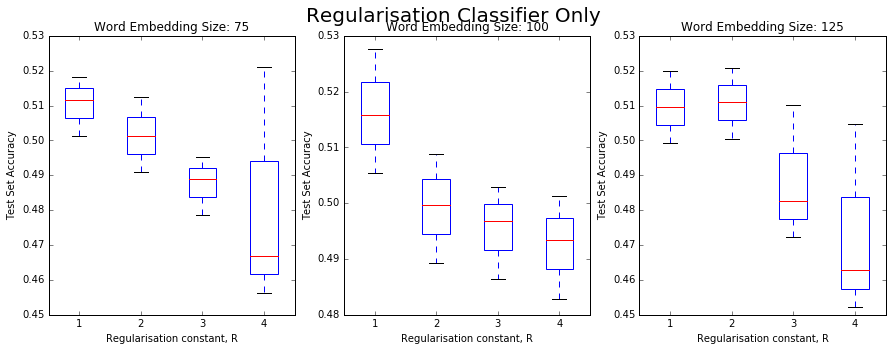

In [20]:
## Results from the regularization exercize
L2a_75 = [[0.50126380599999998, 0.51171999999999995, 0.518111557],[0.490903806, 0.50136000000000003, 0.51232758899999997],[0.47854380600000002, 0.48899999999999999, 0.49525619700000001],[0.45634380600000002, 0.46679999999999999, 0.52116193499999997]]
L2a_100 = [[0.50534380599999995, 0.51580000000000004, 0.52766423200000001],[0.48926380600000002, 0.49972, 0.50878818599999998],[0.48634380599999999, 0.49680000000000002, 0.50287618300000003],[0.48290380599999999, 0.49336000000000002, 0.50129649799999998]]
L2a_125 = [[0.49922380599999999, 0.50968000000000002, 0.51991874999999999],[0.500503806, 0.51095999999999997, 0.52067534900000001],[0.47218380599999998, 0.48264000000000001, 0.51013596299999997],[0.45226380599999999, 0.46272000000000002, 0.50480149200000002]]
L2b_75 = [[0.51262380600000002, 0.52307999999999999, 0.53898509400000005],[0.50766380600000005, 0.51812000000000002, 0.52798265700000002],[0.47994380599999997, 0.4904, 0.50085657699999997],[0.45938380600000001, 0.46983999999999998, 0.47821305200000003]]
L2b_100 = [[0.50138380599999999, 0.51183999999999996, 0.51763378999999998],[0.505503806, 0.51595999999999997, 0.52466218399999998],[0.481023806, 0.49147999999999997, 0.50400565399999997]]

# L2a
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
plt.suptitle('Regularisation Classifier Only', fontsize=20)

bplot1 = axes[0].boxplot(L2a_75,vert=True,patch_artist=True)   
axes[0].set_xlabel('Regularisation constant, R')
axes[0].set_ylabel('Test Set Accuracy')
axes[0].set_title('Word Embedding Size: 75')

bplot1 = axes[1].boxplot(L2a_100,vert=True,patch_artist=True)  
axes[1].set_xlabel('Regularisation constant, R')
axes[1].set_ylabel('Test Set Accuracy')
axes[1].set_title('Word Embedding Size: 100')

bplot1 = axes[2].boxplot(L2a_125,vert=True,patch_artist=True)   
axes[2].set_xlabel('Regularisation constant, R')
axes[2].set_ylabel('Test Set Accuracy')
axes[2].set_title('Word Embedding Size: 125')

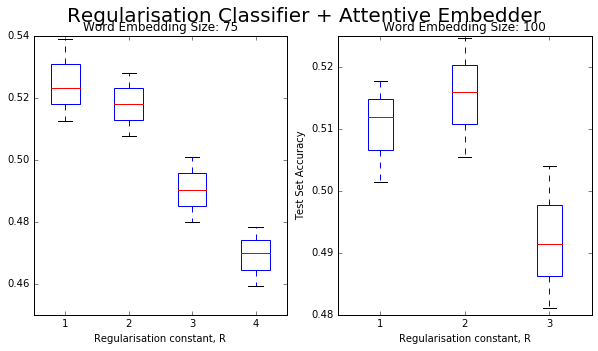

In [21]:
# L2b
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plt.suptitle('Regularisation Classifier + Attentive Embedder', fontsize=20)
bplot1 = axes[0].boxplot(L2b_75,vert=True,patch_artist=True)   
axes[0].set_xlabel('Regularisation constant, R')
axes[0].set_title('Word Embedding Size: 75')
bplot1 = axes[1].boxplot(L2b_100,vert=True,patch_artist=True)  
plt.xlabel('Regularisation constant, R')
axes[1].set_ylabel('Test Set Accuracy')
axes[1].set_title('Word Embedding Size: 100')

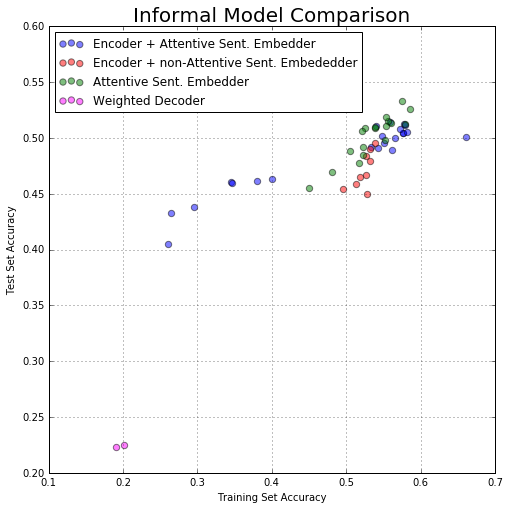

In [24]:
# Results of cross validation exercise
asean_train = np.array([0.543,0.6616,0.5774,0.4004,0.2604,0.3802,0.2948,0.5766,0.3454,0.346,0.2648,0.5794,0.5758,0.5482,0.5514,0.5618,0.5654,0.5334,0.5398,0.5816,0.5724,0.5594])
asean_test = np.array([0.491,0.5006,0.5128,0.4632,0.405,0.4612,0.4378,0.5042,0.4606,0.4598,0.4326,0.5114,0.5046,0.5022,0.4954,0.4894,0.5002,0.492,0.5112,0.5054,0.508,0.514])
en_train = np.array([0.5384,0.5316,0.5272,0.5322,0.5264,0.5184,0.5278,0.5136,0.496])
en_test = np.array([0.4952,0.4898,0.4838,0.4796,0.4668,0.4652,0.4496,0.459,0.4542])
se_train = np.array([0.4968,0.5134,0.4366,0.473,0.4972,0.4804,0.4894,0.5004])
se_test = np.array([0.467,0.4742,0.4286,0.4482,0.4624,0.471,0.4692,0.4776])
sea_train = np.array([0.5864,0.56,0.5756,0.5568,0.5522,0.5232,0.5796,0.5538,0.5254,0.4506,0.5048,0.5214,0.4814,0.5232,0.5382,0.5172,0.5388,0.5534])
sea_test = np.array([0.5264,0.5138,0.5334,0.5148,0.4978,0.4844,0.5122,0.5108,0.5094,0.4552,0.4884,0.5064,0.4694,0.492,0.509,0.4774,0.5098,0.5188])
wdec_train = np.array([0.201,0.1906])
wdec_test = np.array([0.2252,0.2228])

# Comparison of models
plt.figure(figsize=(8,8))
area = 40
colors = 'Blue'
plt.scatter(asean_train,asean_test, s=area, c='Blue', alpha=0.5,label='Encoder + Attentive Sent. Embedder')
plt.scatter(en_train,en_test, s=area, c='Red', alpha=0.5,label='Encoder + non-Attentive Sent. Embededder')
plt.scatter(sea_train,sea_test, s=area, c='Green', alpha=0.5,label='Attentive Sent. Embedder')
plt.scatter(wdec_train,wdec_test, s=area, c= 'Magenta', alpha=0.5,label='Weighted Decoder')
plt.xlabel('Training Set Accuracy')
plt.ylabel('Test Set Accuracy')
plt.title('Informal Model Comparison', fontsize=20)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

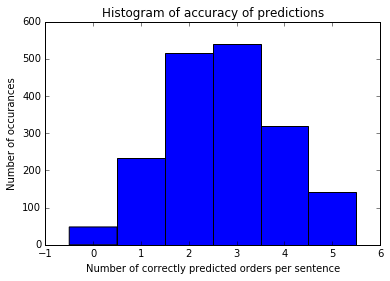

In [15]:
# Plotting a histogram of the counts of the error rate per sentence
try:
    boolarr=dev_predicted==test_feed_dict[model.order] #test_orders
except:
    boolarr=dev_predicted==test_feed_dict['order'] 
n_correct_per_story = list(boolarr.sum(axis=1))
import matplotlib.pyplot as plt
x=np.array(n_correct_per_story[:1800])
% matplotlib inline
plt.hist(x,np.arange(7)-0.5)#bins=5)
plt.title('Histogram of accuracy of predictions')
plt.xlabel('Number of correctly predicted orders per sentence')
plt.ylabel('Number of occurances')

### Appendix C: Code graveyard
Graveyard of fully-functioning model components that weren't ultimately used (RIP).

In [16]:
# =========================== COMPONENT GRAVEYARD ===========================

class Attention(object):
    def __init__(self, scorer_size, encoder_size, sent_embed_size):
        """
        Builds an attention mechanism based on Logeswaran et al. (2017)
        Uses a relu instead of a tanh for the activation in the attention MLP, which has
        input size sent_embed_size + encoder.cell_size, hidden size scorer_size, and output size 1
        :param scorer_size:
        :param encoder_size:
        :param sent_embed_size:
        """

        self.hidden_size = scorer_size
        self.input_size = encoder_size + sent_embed_size
        self.sent_embed_size = sent_embed_size
        self.n_sents = 5
        self.output_size = 1
        self.initializer = tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32)

        with tf.variable_scope('Attn', reuse=None):
            with tf.variable_scope('Hidden', reuse=None):
                self.HiddenW = tf.get_variable('weights', [self.input_size, self.hidden_size], initializer=self.initializer)
                self.HiddenB = tf.get_variable('biases', [self.hidden_size], initializer=tf.zeros_initializer)
                # self.HiddenW = tf.get_variable(
                #     'weights', initializer=np.load('pretrained/N500/Attn_Hidden_weights.npy'), trainable=False)
                # self.HiddenB = tf.get_variable(
                #     'biases', initializer=np.load('pretrained/N500/Attn_Hidden_biases.npy'), trainable=False)

            with tf.variable_scope('Output', reuse=None):
                self.OutputW = tf.get_variable('weights', [self.hidden_size, self.output_size], initializer=self.initializer)
                self.OutputB = tf.get_variable('biases', [1, self.output_size], initializer=tf.zeros_initializer)
                # self.OutputW = tf.get_variable(
                #     'weights', initializer=np.load('pretrained/N500/Attn_Output_weights.npy'), trainable=False)
                # self.OutputB = tf.get_variable(
                #     'biases', initializer=np.load('pretrained/N500/Attn_Output_biases.npy'), trainable=False)

    @property
    def l2_loss(self):
        return tf.nn.l2_loss(self.HiddenW) + tf.nn.l2_loss(self.OutputW)

    def attention_weights(self, s_t, h_t):
        """
        Computes the attention weights given the sentence embedding matrix and last read state vector.
        The attention weight is a scalar for each sentence in a story.
        The softmax-scaled weights are used as probabilities for positions.
        :param s_t: [batch_size x sent_embed_size]
        :param h_t: [batch_size x encoder.cell_size]
        :return: Not-softmaxed attention weights
        """

        batch_size = get_this_batch_size(h_t)

        # expand the context [batch_size x 5 x sent_embed_size]
        context = tf.tile(tf.expand_dims(h_t, 1), [1, 5, 1])

        # concatenate sentence embeddings and context:[batch_size x 5 x (cell_size + sent_embed_size)]
        concatenated = tf.concat(2, [s_t, context])
        inputs = tf.reshape(concatenated, [-1, self.input_size])  # [batch_size*5 x 1 x input_size]

        # hidden: [batch_size*5 x 1 x hidden_size]
        with tf.variable_scope('Attn/Hidden', reuse=True):
            affine = tf.matmul(inputs, self.HiddenW) + self.HiddenB  # [batch_size*5 x 1 x hidden_size]
            hidden = tf.nn.relu(affine)

        # output: [batch_size x 5] (squeezed off last dimension)
        # not softmaxed
        with tf.variable_scope('Attn/Output', reuse=True):
            affine = tf.matmul(hidden, self.OutputW) + self.OutputB
            output = tf.reshape(tf.squeeze(affine), [batch_size, self.n_sents])

        return output

    def attention_readout(self, s_t, h_t):
        """
        Computes the attention readout given the sentence embedding matrix and last read state vector.
        The attention readout is computed by:
        - softmaxing sentence attention weights for each story (normalisation by story)
        - broadcast multiplying each sentence embedding by the softmaxed weight corresponding to it
        - sum over sentences in a story
        :param s_t: [batch_size x sent_embed_size]
        :param h_t: [batch_size x encoder/decoder_cell_size]
        :return: [batch_size x sent_embed_size]
        """
        # s_t is [batch_size x 5 x sent_embed_size]

        # batch_size x 5
        output = self.attention_weights(s_t, h_t)

        # softmax and add dimension to multiply back on s_t
        # batch_size x 5 x 1
        softmaxed_output = tf.expand_dims(tf.nn.softmax(output), 2)

        # elementwise multiplication with broadcasting
        attn_arr = tf.mul(softmaxed_output, s_t)

        # rowwise sum: batch_size x sent_embed_size
        attn_readout = tf.reduce_sum(attn_arr, 1)

        return attn_readout


class Encoder(object):
    def __init__(self, encoder_size, sent_embed_size, read_cycles, attention):
        """
        :param encoder_size: typically sent_embed_size
        :param read_cycles:
        """
        self.cell_size = encoder_size
        self.sent_embed_size = sent_embed_size
        self.output_size = sent_embed_size + encoder_size
        self.read_cycles = read_cycles
        self.attention = attention
        init = tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32)
        with tf.variable_scope('Encoder', reuse=None):
            self.encoder_cell = tf.nn.rnn_cell.GRUCell(encoder_size, activation=tf.nn.relu)
            self.state_projector = tf.get_variable(
                'StateProjector', [sent_embed_size, encoder_size], initializer=init)
            self.output_projector = tf.get_variable(
                'OutputProjector', [sent_embed_size, self.output_size], initializer=init)
            self.skipW = tf.get_variable('SkipWeights', initializer=[0.1, 0.1, 0.1, 0.1, 0.1, 0.5])

    @property
    def l2_loss(self):
        return tf.nn.l2_loss(self.state_projector) + tf.nn.l2_loss(self.output_projector)

    def encode(self, embedded, context):
        """
        :param context:
        :param embedded:  [batch_size x 5 x sent_embed_size]
        :return:
        h_t: encoding after self.read_cycles [batch_size x (sent_embed_size+cell_size)]
        context: [batch_size x cell_size]
        """
        batch_size = get_this_batch_size(embedded)

        h_t = tf.zeros([batch_size, self.output_size])
        state = tf.matmul(context, self.state_projector)  # [batch_size x cell_size]

        for t in range(self.read_cycles):
            # print(t, h_t.get_shape(), context.get_shape())
            # raw_output: [batch_size x cell_size]

            if t == 0:
                reuse_bool = None
            else:
                reuse_bool = True

            with tf.variable_scope('Encoder', reuse=reuse_bool):
                raw_output, state = self.encoder_cell(
                    inputs=h_t, state=state)

            # attn_vec: [batch_size x sent_embed_size]
            attn_readout = self.attention.attention_readout(embedded, raw_output)
            # attn_readout = tf.zeros(shape=[batch_size, self.sent_embed_size], dtype=tf.float32)

            h_t = tf.concat(1, [raw_output, attn_readout])

        return h_t, state

    def encode_with_skip(self, embedded, context):
        h_t, state = self.encode(embedded, context)
        w = self.skipW / tf.reduce_sum(self.skipW)
        projected_embeddings = [
            w[i] * tf.matmul(tensor, self.output_projector) for i, tensor in enumerate(tf.unpack(embedded, axis=1))]
        h_w = tf.add_n(projected_embeddings) + (w[5] * h_t)
        # embed = [skipW[0] * embed_attn[i] + skipW[1] * embed_init[i] for i in range(len(embed_attn))]
        return h_w, state


class EncoderDecoder(object):
    def __init__(self, encoder_size, sent_embed_size, read_cycles, scorer_size, affine_decoder=True):
        """
        :param encoder_size: typically sent_embed_size
        :param read_cycles:
        :param scorer_size:
        """
        self.sent_embed_size = sent_embed_size
        self.cell_size = encoder_size
        self.affine_decoder = affine_decoder

        self.attention = Attention(
            scorer_size=scorer_size,
            encoder_size=encoder_size,
            sent_embed_size=sent_embed_size)

        self.encoder = Encoder(encoder_size, sent_embed_size, read_cycles, self.attention)
        if affine_decoder:
            self.decoder = AffineDecoder(encoder_size)
        else:
            self.decoder = Decoder(encoder_size, sent_embed_size, self.attention)

    @property
    def l2_loss(self):
        return self.decoder.l2_loss + self.encoder.l2_loss

    def encode(self, *args):
        return self.encoder.encode(*args)

    def encode_with_skip(self, *args):
        return self.encoder.encode_with_skip(*args)

    def loss(self, *args):
        # self.reg * (self.decoder.l2_loss + self.encoder.l2_loss)
        return self.decoder.loss(*args)

    def predict(self, *args):
        return self.decoder.predict(*args)


class Decoder(object):
    def __init__(self, encoder_size, sent_embed_size, attention):
        self.cell_size = encoder_size
        self.sent_embed_size = sent_embed_size
        self.attention = attention

        with tf.variable_scope('Decoder', reuse=None):
            self.decoder_cell = tf.nn.rnn_cell.GRUCell(self.cell_size, activation=tf.nn.relu)

    def decode(self, embedded, context, pos_order_list, train_mode=True):
        """
            Decoder.
            :param embedded: [batch_size x target_size x sent_embed_size]
            :param context:
            :param pos_order_list: [target_size x batch_size] Can be none if train=False
            :param train_mode: flag, used to determine:
                    - what input to use for the decoder at each step
            :return: unsoftmaxed logits [batch_size x 5 x 5] with
                    story x output sentence position x probabilities of input sentence indices
            """
        # batch_size = THIS_BATCH_SIZE
        # context = bw_state

        this_batch_size = get_this_batch_size(embedded)
        static_batch_size = embedded.get_shape()[0].value
        target_size = 5

        x_prev = tf.zeros([this_batch_size, self.sent_embed_size], dtype=embedded.dtype)
        embedded_flat = tf.reshape(embedded, [-1, self.sent_embed_size])

        logits_list = []

        for t in range(target_size):
            # print(t)
            # if not training, reuse weights. if training, do not reuse weights at t = 0
            reuse_bool = True
            if train_mode is True and t == 0:
                reuse_bool = None

            with tf.variable_scope('Decoder', reuse=reuse_bool):
                raw_output, context = self.decoder_cell(
                    inputs=x_prev,
                    state=context)

            # attn_output [batch_size x 5] (trailing x1 squeezed off)
            # attn_output[i,j] at time t is prob of jth sent in ith story having position t
            # always reuse attention weights when decoding
            attn_output = self.attention.attention_weights(embedded, raw_output)

            # append the unsoftmaxed attention weights for cross-entropy calculations
            # save for later cross entropy
            logits_list.append(attn_output)

            # Next input
            # At training time, use the true sentence at the previous time
            # For testing, use the predicted sentence at the previous time
            if train_mode:
                i_prev = pos_order_list[t]
            else:
                # argmax seems to automatically return int64 indices
                softmax_attn_output = tf.nn.softmax(attn_output)  # I think softmax is monotonic, but just in case...
                i_prev = tf.to_int32(tf.arg_max(softmax_attn_output, 1))

            i_prev.set_shape([static_batch_size, ])

            index = (tf.range(0, this_batch_size) * target_size) + i_prev
            x_prev = tf.gather(embedded_flat, index)  # input into next step
            # print(x_prev.get_shape())

        logits = tf.pack(logits_list, 2)
        logits.set_shape([static_batch_size, target_size, target_size])

        # always return unsoftmaxed logits from decoder
        return logits

    @property
    def l2_loss(self):
        return 0

    @staticmethod
    def loss_from_logits(logits, order):
        return tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, order))

    @staticmethod
    def predict_from_logits(logits):
        softmaxed_logits = tf.pack([tf.nn.softmax(tensor) for tensor in tf.unpack(logits, axis=1)], axis=1)
        return tf.arg_max(softmaxed_logits, 2)

    def loss(self, embedded, context, pos_order_list, order):
        """
        Computes logits using the decoder in training mode.
        Then computes softmax cross entropy with the true order to get loss.
        :param embedded:
        :param context:
        :param pos_order_list: 5 * [batch_size, ]
        :param order: [batch_size x 5] This size means we have to use sparse
        :return:
        """
        # get unsoftmaxed logits from decoder
        logits = self.decode(embedded, context, pos_order_list, train_mode=True)

        # pass unsoftmaxed decoder logits into crossentropy
        # do not make negative because of other dependencies
        return self.loss_from_logits(logits, order)

    def predict(self, embedded, context):
        """
        Computes logits using the decoder in prediction mode.
        Then returns for each story in the batch a prediction vector.
        :param embedded: [batch_size x target_size x sent_embed_size]
        :param context: [batch_size x encoder.cell_size]
        :return: predict [batch_size x target_size]
        """
        logits = self.decode(embedded, context, None, train_mode=False)
        # story x output sentence position x probabilities of input sentence indices
        # need to unpack and repack because can't specify axis for softmax
        return self.predict_from_logits(logits)


class Skip2Decoder(Decoder):
    def __init__(self, encoder_size, sent_embed_size, attention):
        super(Skip2Decoder, self).__init__(encoder_size, sent_embed_size, attention)
        initializer = tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32)
        with tf.variable_scope('Decoder', reuse=None):
            self.skipW = tf.get_variable('SkipWeights', initializer=[0.5, 0.5])
            self.projector = tf.get_variable('Projector', [self.sent_embed_size, 5], initializer=initializer)

    def decode_with_skip(self, embedded, context, pos_order_list, train_mode):
        decoded = self.decode(embedded, context, pos_order_list, train_mode)
        w = self.skipW / tf.reduce_sum(self.skipW)
        projected_embeddings = [
            tf.nn.relu(tf.matmul(tensor, self.projector)) for i, tensor in enumerate(tf.unpack(embedded, axis=1))]
        logits = w[0] * tf.pack(projected_embeddings, axis=1) + (w[1] * decoded)
        return logits

    def loss(self, embedded, context, pos_order_list, order):
        logits = self.decode_with_skip(embedded, context, pos_order_list, train_mode=True)
        self.loss_from_logits(logits, order)

    def predict(self, embedded, context):
        logits = self.decode_with_skip(embedded, context, None, train_mode=False)
        # story x output sentence position x probabilities of input sentence indices
        # need to unpack and repack because can't specify axis for softmax
        return self.predict_from_logits(logits)

    @property
    def l2_loss(self):
        return tf.nn.l2_loss(self.projector)


class AffineDecoder(object):
    def __init__(self, encoder_size):

        with tf.variable_scope('Decoder', reuse=None):
            self.projector_weights = tf.get_variable('weights', [encoder_size, 25])
            self.projector_biases = tf.get_variable('biases', [1, 25])
            # self.projector_weights = tf.get_variable(
            #     'weights', initializer=np.load('pretrained/N500/Decoder_weights.npy'), trainable=False)
            # self.projector_biases = tf.get_variable(
            #     'biases', initializer=np.load('pretrained/N500/Decoder_biases.npy'), trainable=False)

    def decode(self, context):
        logits_flat = tf.matmul(context, self.projector_weights) + self.projector_biases
        logits = tf.reshape(logits_flat, [-1, 5, 5])
        return logits

    def loss(self, embedded, context, pos_order_list, order):
        """Takes extra dummy arguments for consistency with the main Decoder function."""
        logits = self.decode(context)
        return tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, order))

    def predict(self, embedded, context):
        """Takes extra dummy arguments for consistency with the main Decoder function."""
        logits = self.decode(context)
        softmaxed_logits = tf.pack([tf.nn.softmax(tensor) for tensor in tf.unpack(logits, axis=1)], axis=1)
        return tf.arg_max(softmaxed_logits, 2)

    @property
    def l2_loss(self):
        return tf.nn.l2_loss(self.projector_weights)


class WeightedDecoder(object):
    def __init__(self, encoder_size, sent_embed_size, attention):
        self.affine = AffineDecoder(encoder_size)
        self.decoder = Decoder(encoder_size, sent_embed_size, attention)
        with tf.variable_scope('Decoder', reuse=None):
            self.skipW = tf.get_variable('SkipWeights',
                                         [2], initializer=tf.random_normal_initializer(stddev=0.1))

    def decode(self, embedded, context, pos_order_list, train_mode=True):
        logits = self.decoder.decode(embedded, context, pos_order_list, train_mode)
        skip_logits = self.affine.decode(context)
        w = self.skipW / tf.reduce_sum(self.skipW)
        w_logits = (w[0] * logits) + (w[1] * skip_logits)
        return w_logits

    def loss(self, embedded, context, pos_order_list, order):
        logits = self.decode(embedded, context, pos_order_list, train_mode=True)
        return tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, order))

    def predict(self, embedded, context):
        logits = self.decode(embedded, context, None, train_mode=False)
        softmaxed_logits = tf.pack([tf.nn.softmax(tensor) for tensor in tf.unpack(logits, axis=1)], axis=1)
        return tf.arg_max(softmaxed_logits, 2)

    @property
    def l2_loss(self):
        return self.affine.l2_loss + self.decoder.l2_loss

In [17]:
# =========================== MODEL GRAVEYARD ===========================
# Non-attentive sentence embedder
class SentEmbedderModel(Model):
    def build(self):
        self.worder = WordEmbedder(self.word_embed_size, self.vocab_size)
        self.embedder = SentenceEmbedder(self.sent_embed_size)

        # WORD EMBEDDINGS: list 5 *[batch_size x word_embed_size]
        words_embedded = self.worder.embed(self.story)

        # SENTENCE EMBEDDINGS: list 5*[batch_size x sent_embed_size]
        output_list, _, output_state = self.embedder.embed(words_embedded, self.seq_lens, None)
        embedded = tf.pack(output_list, axis=1)
        self.loss_op = self.simple_loss(embedded, self.order)
        self.predict_op = self.simple_predict(embedded)

        return None


# Attentive sentence embedding model with skip connection: same as MODEL
class AttnSentEmbedderModel(Model):
    def build(self):
        self.worder = WordEmbedder(self.word_embed_size, self.vocab_size)
        self.embedder = AttnSentenceEmbedder(self.sent_embed_size)
        self.classifier = NonLinearClassifier(5*self.sent_embed_size, 25)

        static_batch_size = self.story.get_shape()[0].value

        # WORD EMBEDDINGS: list 5 *[batch_size x word_embed_size]
        words_embedded = self.worder.embed(self.story)

        # SENTENCE EMBEDDINGS: list 5*[batch_size x sent_embed_size]
        output_list, _ = self.embedder.embed_with_skip(words_embedded, self.seq_lens, None)
        embedded = tf.pack(output_list, axis=1)
        embedded.set_shape([static_batch_size, self.target_size, self.sent_embed_size])
        embedded = self.classifier.classify(embedded)

        reg_loss = self.reg * (
            self.classifier.l2_loss + self.embedder.l2_loss)

        self.loss_op = self.simple_loss(embedded, self.order) + reg_loss
        self.predict_op = self.simple_predict(embedded)

        return None


# Attentive skip encoder with non-attentive sentence embedding
class SkipEncoderModel(Model):
    def build(self):
        self.worder = WordEmbedder(self.word_embed_size, self.vocab_size)
        self.embedder = SentenceEmbedder(cell_size=self.sent_embed_size)
        self.encoder = EncoderDecoder(
            encoder_size=self.encoder_size,
            sent_embed_size=self.sent_embed_size,
            read_cycles=self.read_cycles,
            scorer_size=self.attn_scorer_size,
            affine_decoder=True)

        pos_order_list = [tf.squeeze(tensor) for tensor in tf.unpack(self.pos_order, axis=0)]

        # WORD EMBEDDINGS: list 5 *[batch_size x word_embed_size]
        words_embedded = self.worder.embed(self.story)

        # # SENTENCE EMBEDDINGS: list 5*[batch_size x sent_embed_size]
        output_list, _, output_state = self.embedder.embed(
            words_embedded, self.seq_lens, None)
        embedded = tf.pack(output_list, axis=1)

        # ENCODING
        read_output, read_state = self.encoder.encode_with_skip(embedded, output_state)

        # DECODING, SCORING, PREDICTING
        self.loss_op = self.encoder.loss(embedded, read_state, pos_order_list, self.order)
        self.predict_op = self.encoder.predict(embedded, read_state)

        return None

    
# Attentive skip encoder with attentive sentence embedding
class AttnSkipEncoderModel(Model):
    def build(self):
        self.worder = WordEmbedder(self.word_embed_size, self.vocab_size)
        self.embedder = AttnSentenceEmbedder(self.sent_embed_size)
        self.encoder = EncoderDecoder(
            encoder_size=self.encoder_size,
            sent_embed_size=self.sent_embed_size,
            read_cycles=self.read_cycles,
            scorer_size=self.attn_scorer_size,
            affine_decoder=True)

        pos_order_list = [tf.squeeze(tensor) for tensor in tf.unpack(self.pos_order, axis=0)]

        # WORD EMBEDDINGS: list 5 *[batch_size x word_embed_size]
        words_embedded = self.worder.embed(self.story)

        # # SENTENCE EMBEDDINGS: list 5*[batch_size x sent_embed_size]
        output_list, output_state = self.embedder.embed_with_skip(
            words_embedded, self.seq_lens, None)
        embedded = tf.pack(output_list, axis=1)

        # ENCODING
        read_output, read_state = self.encoder.encode_with_skip(embedded, output_state)

        reg_loss = self.reg * (self.embedder.l2_loss + self.encoder.l2_loss)

        # DECODING, SCORING, PREDICTING
        self.loss_op = self.encoder.loss(embedded, read_state, pos_order_list, self.order) + reg_loss
        self.predict_op = self.encoder.predict(embedded, read_state)

        return None


# Basic non-affine decoder model
class DecoderModel(Model):
    def build(self):
        self.worder = WordEmbedder(self.word_embed_size, self.vocab_size)
        self.embedder = AttnSentenceEmbedder(self.sent_embed_size)
        self.encoder = EncoderDecoder(
            encoder_size=self.encoder_size,
            sent_embed_size=self.sent_embed_size,
            read_cycles=self.read_cycles,
            scorer_size=self.attn_scorer_size,
            affine_decoder=False)

        pos_order_list = [tf.squeeze(tensor) for tensor in tf.unpack(self.pos_order, axis=0)]

        # WORD EMBEDDINGS: list 5 *[batch_size x word_embed_size]
        words_embedded = self.worder.embed(self.story)

        # # SENTENCE EMBEDDINGS: list 5*[batch_size x sent_embed_size]
        output_list, output_state = self.embedder.embed_with_skip(
            words_embedded, self.seq_lens, None)
        embedded = tf.pack(output_list, axis=1)

        # ENCODING
        read_output, read_state = self.encoder.encode_with_skip(embedded, output_state)

        # DECODING, SCORING, PREDICTING
        self.loss_op = self.encoder.loss(embedded, read_state, pos_order_list, self.order)
        self.predict_op = self.encoder.predict(embedded, read_state)

        return None

In [18]:
# =========================== UNUSED FUNCTIONS ===========================
# These were not needed for the final model implementation, but were essential during the
# development process

def argparser(verbose=True):
    parser = argparse.ArgumentParser(description='Help me')
    parser.add_argument('-W', '--word', dest='word_embed_size', action='store', default=300, type=int)
    parser.add_argument('-S', '--sent', dest='sent_embed_size', action='store', default=100, type=int)
    parser.add_argument('-M', '--scorer', dest='attn_scorer_size', action='store', default=500, type=int)
    parser.add_argument('-N', '--encoder', dest='encoder_size', action='store', default=1000, type=int)
    parser.add_argument('-R', '--read', dest='read_cycles', action='store', default=5, type=int)
    parser.add_argument('-E', '--epochs', dest='n_epochs', action='store', default=25, type=int)
    parser.add_argument('-L', '--learn', dest='learn_rate', action='store', default=0.001, type=float)
    parser.add_argument('-B', '--batch', dest='batch_size', action='store', default=50, type=int)
    parser.add_argument('-T', '--train', dest='n_train', action='store', default=1000, type=int)
    parser.add_argument('-D', '--dev', dest='n_dev', action='store', default=100, type=int)
    parser.add_argument('-P', '--permute', dest='permute', action='store', default=0, type=int)
    parser.add_argument('-f', '--full', dest='full_run_flag', action='store_true')
    parser.add_argument('-s', '--save', dest='save_flag', action='store_true')
    parser.add_argument('-w', '--write', dest='write_flag', action='store_true')
    parser.add_argument('-sd', '--savedir', dest='save_dir', action='store', default='model/')
    parser.add_argument('-wd', '--writedir', dest='write_dir', action='store', default='res/')
    parser.add_argument('-i', '--import', dest='saved_path', action='store', default=None)
    parser.add_argument('-d', '--do-not-stop', dest='stop_flag', action='store_false')
    parser.add_argument('-r', '--reg', dest='reg', action='store', default=0, type=float)
    parser.add_argument('-p', '--permutefrac', dest='permute_frac', action='store', default=0, type=float)
    args = parser.parse_args()

    # the full run flag overrides specification of training/dev sizes
    if args.full_run_flag:
        args.n_train = None
        args.n_dev = None

    # Create the parameter string for use in write_to and model save_to
    params = args.encoder_size, args.word_embed_size, args.sent_embed_size, args.attn_scorer_size, args.read_cycles, \
             args.n_epochs, args.learn_rate, args.batch_size, args.n_train, args.n_dev, args.permute, args.reg, \
             args.permute_frac
    param_str = 'N{}-W{}-S{}-M{}-R{}-E{}-L{}-B{}-T{}-D{}-P{}-r{}-p{}'.format(*params)
    if verbose is False:
        param_str = 'W{}-S{}-E{}-L{}-B{}-r{}-p{}'.format(
            args.word_embed_size, args.sent_embed_size, args.n_epochs,
            args.learn_rate, args.batch_size, args.reg, args.permute_frac)

    # Set result print destination. If writing not enabled, set write_to None should print to stdout
    if args.write_flag is True:
        if not os.path.exists(args.write_dir):
            os.mkdir(args.write_dir)
        write_path = ''.join([args.write_dir, 'res_', param_str, '.txt'])
        write_to = open(write_path, 'a')
    else:
        write_to = None

    # Set model save destination
    if args.save_flag is True:
        if not os.path.exists(args.save_dir):
            os.mkdir(args.save_dir)
        save_path = ''.join([args.save_dir, 'model_', param_str, '.ckpt'])
    else:
        save_path = None

    # Print parameters at start of results file in human readable format
    args_dict = vars(args)
    if verbose:
        print('===== Parameters =====', file=write_to)
        [print(key, args_dict[key], file=write_to) for key in sorted(args_dict.keys())]

    return args, args_dict, write_to, save_path


def save_trained_vars(model, scope):
    save_vars = [v for v in tf.all_variables() if v.name.startswith(scope)]

    for v in save_vars:
        computed = model.sess.run(v)
        save_name = 'pretrained/' + str(v.name).replace('/', '_').split(':')[0] + '.npy'
        print(save_name, computed.shape)
        np.save(save_name, computed)


def retrieve_weights(SubModel, scopes):
    """

    :param SubModel: class of model to retrieve weights for
    :param scopes: the scopes to retrieve
    :return:
    """
    args, args_dict, _, _ = argparser()
    model = SubModel(args_dict, None)
    model.build()
    model.load()
    for scope in scopes:
        save_trained_vars(model, scope)


def main_predict(SubModel, args_dict, feed_dict):
    # Minimum args_dict at test time has keys: word_embed_size, sent_embed_size, attn_scorer_size, saved_path
    model = SubModel(args_dict)
    model.build()
    model.load()
    return model.predict(feed_dict)


def main(SubModel):
    """
    Build, train, save, write models.
    :param SubModel: a subclass of Model with at least an overriding build method
    :return:
    """
    # Retrieve arguments
    args, args_dict, write_to, save_path = argparser()

    # ===== DATA LOADING ======
    # Load data of required size
    pipeline = Preprocess(args.batch_size, args.n_train, args.n_dev, args.permute, args.permute_frac)
    train_batches, dev_batches = pipeline.pipeline()
    args_dict['vocab_size'] = pipeline.vocab_size

    # ===== FINALLY, START MODELLING =====
    # Initialise model (starts a session)
    model = SubModel(args_dict, save_path)
    assert model.sess is not None

    # Build model using training vocabulary size
    model.build()

    # Prepare full train and dev feed_dicts for accuracy reporting
    train_feed_dict = pipeline.stack_batches(*train_batches, model=model)
    dev_feed_dict = pipeline.stack_batches(*dev_batches, model=model)

    # Train model
    model.train(args_dict, train_feed_dict, dev_feed_dict, train_batches, write_to)

    # Closing
    if args.save_flag is True:
        model.save()

    if write_to is not None:
        write_to.close()

    if model.sess is not None:
        model.sess.close()


def validate_main(SubModel):
    """
    Build, train, save, write models.
    :param SubModel: a subclass of Model with at least an overriding build method
    :return:
    """
    # Retrieve arguments
    args, args_dict, write_to, save_path = argparser(verbose=False)

    # ===== DATA LOADING ======
    # Load data of required size
    pipeline = Preprocess(args.batch_size, args.n_train, args.n_dev, args.permute)

    for k in range(5):
        train_batches, dev_batches = pipeline.validate()

        # ===== FINALLY, START MODELLING =====
        # Initialise model (starts a session)
        model = SubModel(args_dict, save_path)
        assert model.sess is not None

        # Build model using training vocabulary size
        model.build()

        # Prepare full train and dev feed_dicts for accuracy reporting
        train_feed_dict = pipeline.stack_batches(*train_batches, model=model)
        dev_feed_dict = pipeline.stack_batches(*dev_batches, model=model)

        # Train model
        model.train(args_dict, train_feed_dict, dev_feed_dict, train_batches, write_to, False)

        if model.sess is not None:
            model.sess.close()

        tf.reset_default_graph()

    if write_to is not None:
        write_to.close()

Script for extracting GloVe embeddings for our vocabulary from pretrained:
```
from shared import Preprocess
import numpy as np
import argparse
parser = argparse.ArgumentParser(description='Extract GloVe embeddings using our data vocabulary.')
parser.add_argument('-W', '--word', dest='word_embed_size', action='store', default=100, type=int)
parser.add_argument('--src', dest='src_path', action='store', default=None)
parser.add_argument('--save', dest='save_path', action='store', default=None)
args = parser.parse_args()

pipeline = Preprocess()
data_train, data_dev = pipeline.load_data()
data_train.extend(data_dev)
train_lists = pipeline.build_vocab(data_train)
vocab = pipeline.vocab
print(len(vocab))
word_embed_size = args.word_embed_size

if args.src_path is None:
    args.src_path = 'glove.6B.300d.txt'
if args.save_path is None:
    args.save_path = 'embeddings/GloVe300.npy'

# 2. Load GloVe embeddings
embed_file = open(args.src_path, 'r')

# 3. Read data in a dictionary, keep a log of
# not found words (the index to the words)
myGlove = {}
for line in embed_file:
    items = line.replace('\r', '').replace('\n', '').split(' ')
    splitLine = line.split()
    word = splitLine[0]
    embed = [float(val) for val in splitLine[1:]]
    myGlove[word] = embed

embed_file.close()

# 4. Bring the embeddings corresponding to all words of our vocabulary
# from GLoVe to a dictionary (named 'found')
# keep a list of all words not found in the GLoVe files in a second
# directory named 'not_found'

not_found = []
found = np.zeros([len(vocab), word_embed_size])
oov = np.zeros([1, word_embed_size])
for word in vocab:
    if word in myGlove:
        found[vocab[word],] = myGlove[word]
        oov += myGlove[word]
    else:
        not_found.append(vocab[word])
# calculate the embedding of the <OOV> token as the mean value of imported vectors
oov /= len(found)

# 5. Set all not found words (~2% of dictionary) to the oov token
for i in range(len(not_found)):
    found[not_found[i],] = not_found[i]

# 6. Save the embedding vector for later use
# CHANGE FILE_NAME ACCORDINGLY

from tempfile import TemporaryFile

outfile = TemporaryFile()
np.save(args.save_path, found, allow_pickle=True, fix_imports=True)


```

## <font color='red'>Assessment 2</font>: Assess Description (30 pts) 

We will mark the description along the following dimensions: 

* Clarity (10pts: very clear, 0pts: we can't figure out what you did, or you did nothing)
* Creativity (10pts: we could not have come up with this, 0pts: Use only the provided model)
* Substance (10pts: implemented complex state-of-the-art classifier, compared it to a simpler model, 0pts: Only use what is already there)

## <font color='orange'>Mark</font>:  Your solution to Task 2 is marked with ** __ points**.
---

## <font color='orange'>Final mark</font>: Your solution to Assignment 3 is marked with ** __points**. 